In [7]:
#Imports and Setup
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
if not os.path.exists('HistoricalColor-ECCV2012'):
    print("Downloading dataset...")
    os.system("curl http://graphics.cs.cmu.edu/projects/historicalColor/HistoricalColor-ECCV2012-DecadeDatabase.tar > HistoricalColor-ECCV2012-DecadeDatabase.tar")
    os.system("tar -xf HistoricalColor-ECCV2012-DecadeDatabase.tar")
    print("Dataset downloaded and extracted.")

In [9]:

def prepare_data(data_path='HistoricalColor-ECCV2012'):
    """Load and prepare the dataset."""
    all_jpg_paths = [filename for filename in Path(data_path).glob('**/**/*.jpg')]
    print(f'Number of images found: {len(all_jpg_paths)}')

    class_label_mapping = {'1930s': 0, '1940s': 1, '1950s': 2, '1960s': 3, '1970s': 4}

    df = pd.DataFrame(all_jpg_paths, columns=['paths'])
    df['year'] = df['paths'].apply(lambda x: os.path.basename(os.path.dirname(x)))
    df['labels'] = df['year'].map(class_label_mapping)

    feature_data = extract_image_features(df)
    return feature_data, class_label_mapping

In [10]:
def extract_image_features(df):
    """Extract features from all images."""
    print("Extracting features from images...")

    features = {
        'brightness': [], 'contrast': [], 'saturation': [], 'edge_intensity': [],
        'hist_bins': [[] for _ in range(10)],
        'color_stats': [[] for _ in range(6)],
        'valid_indices': []
    }

    for idx, img_path in enumerate(df['paths']):
        try:
            with Image.open(img_path).convert('RGB') as image:
                img_array = np.array(image)
                gray_array = np.array(image.convert("L"))

                # Basic features
                features['brightness'].append(np.mean(gray_array))
                features['contrast'].append(np.std(gray_array))

                # Color stats
                for i in range(3):
                    features['color_stats'][i*2].append(np.mean(img_array[:,:,i]))
                    features['color_stats'][i*2+1].append(np.std(img_array[:,:,i]))

                # Saturation
                r, g, b = img_array[:,:,0]/255.0, img_array[:,:,1]/255.0, img_array[:,:,2]/255.0
                max_rgb = np.maximum(np.maximum(r, g), b)
                min_rgb = np.minimum(np.minimum(r, g), b)
                diff = max_rgb - min_rgb
                sat = np.mean(np.where(max_rgb > 0, diff / max_rgb, 0))
                features['saturation'].append(sat)

                # Histogram features
                hist, _ = np.histogram(gray_array, bins=10, range=(0, 256))
                hist = hist / (hist.sum() or 1)
                for i in range(10):
                    features['hist_bins'][i].append(hist[i])

                # Edge detection
                h, w = gray_array.shape
                if h > 2 and w > 2:
                    dx = np.abs(gray_array[1:, :] - gray_array[:-1, :]).mean()
                    dy = np.abs(gray_array[:, 1:] - gray_array[:, :-1]).mean()
                    features['edge_intensity'].append((dx + dy) / 2)
                else:
                    features['edge_intensity'].append(0)

                features['valid_indices'].append(idx)
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")

    # Create DataFrame with valid images
    df_valid = df.iloc[features['valid_indices']].copy()

    # Add extracted features
    df_valid['brightness'] = features['brightness']
    df_valid['contrast'] = features['contrast']
    df_valid['saturation'] = features['saturation']
    df_valid['edge_intensity'] = features['edge_intensity']

    for i in range(10):
        df_valid[f'hist_bin_{i}'] = features['hist_bins'][i]

    channel_names = ['r_mean', 'r_std', 'g_mean', 'g_std', 'b_mean', 'b_std']
    for i, name in enumerate(channel_names):
        df_valid[name] = features['color_stats'][i]

    print(f"Successfully processed {len(df_valid)} out of {len(df)} images")
    return df_valid

In [11]:
#Dataset and Transforms
def get_transforms():
    """Create data transforms for training and validation."""
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform


class HistoricalColorDataset(Dataset):
    """Dataset class for historical color images."""
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.indices = self.dataframe.index.tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        img_path = self.dataframe.iloc[idx]['paths']
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.dataframe.iloc[idx]['labels']
            if self.transform:
                image = self.transform(image)
            return image, label, actual_idx
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return torch.zeros(3, 224, 224), self.dataframe.iloc[idx]['labels'], actual_idx

In [12]:
#Feature Extraction
def extract_combined_features(dataset, device, batch_size=32):
    """Extract both handcrafted and deep features from images."""
    features = []
    labels = []

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Load pre-trained model for feature extraction
    feature_model = models.efficientnet_b0(weights='DEFAULT').to(device)
    feature_model.eval()
    feature_extractor = nn.Sequential(*list(feature_model.children())[:-1])

    for batch_images, batch_labels, batch_indices in loader:
        batch_images = batch_images.to(device)
        valid_mask = ~torch.all(batch_images == 0, dim=(1, 2, 3))

        # Extract deep features
        with torch.no_grad():
            deep_features = feature_extractor(batch_images).squeeze(-1).squeeze(-1).cpu().numpy()

        for i, (deep_feat, label, actual_idx) in enumerate(zip(deep_features, batch_labels, batch_indices)):
            if not valid_mask[i]:
                continue

            try:
                # Get handcrafted features
                row_idx = dataset.dataset.dataframe.index.get_loc(actual_idx.item())
                row = dataset.dataset.dataframe.iloc[row_idx]

                # Combine handcrafted and deep features
                basic_features = [
                    row['brightness'], row['contrast'],
                    row['saturation'], row['edge_intensity']
                ]

                hist_features = [row[f'hist_bin_{i}'] for i in range(10)]

                color_features = [
                    row['r_mean'], row['r_std'],
                    row['g_mean'], row['g_std'],
                    row['b_mean'], row['b_std']
                ]

                # Use only first 50 deep features
                deep_feat_selected = deep_feat[:50]

                combined = np.concatenate([
                    basic_features, hist_features, color_features, deep_feat_selected
                ])

                features.append(combined)
                labels.append(label.item())
            except Exception as e:
                print(f"Error extracting features: {e}")

    return np.array(features), np.array(labels)

In [13]:
# KNN Model Training and Evaluation
def train_evaluate_knn_model(train_dataset, val_dataset, test_dataset, device):
    """Train and evaluate a KNN model."""
    print("Extracting and processing features...")

    X_train, y_train = extract_combined_features(train_dataset, device)
    X_val, y_val = extract_combined_features(val_dataset, device)
    X_test, y_test = extract_combined_features(test_dataset, device)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    n_components = min(75, X_train_scaled.shape[0] - 1, X_train_scaled.shape[1])
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Find best k using validation set
    best_k = 1
    best_val_acc = 0

    print("Finding optimal k for KNN...")
    for k in range(1, 21, 2):  # Try odd k values from 1 to 19
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit(X_train_pca, y_train)
        val_pred = knn.predict(X_val_pca)
        val_acc = accuracy_score(y_val, val_pred)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_k = k
    # Train final KNN model with best k
    knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
    knn.fit(X_train_pca, y_train)

    # Evaluate on test set
    test_pred = knn.predict(X_test_pca)
    test_acc = accuracy_score(y_test, test_pred)
    mae = mean_absolute_error(y_test, test_pred)
    cm = confusion_matrix(y_test, test_pred)

    print("KNN Results:")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"MAE: {mae:.2f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("KNN Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return test_acc, mae

In [14]:
# CNN Model Definition
class EnhancedCNN(nn.Module):
    """CNN model with EfficientNet backbone."""
    def __init__(self, num_classes=5):
        super(EnhancedCNN, self).__init__()

        # Load pre-trained EfficientNet
        self.backbone = models.efficientnet_b0(weights='DEFAULT')
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        # New classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        # Freeze early layers
        for name, param in self.backbone.named_parameters():
            if 'features.0.' in name or 'features.1.' in name:
                param.requires_grad = False

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)


In [21]:
# CNN Training and Evaluation
def train_evaluate_cnn(train_dataset, val_dataset, test_dataset, device, class_names=None):
    """Train and evaluate CNN model."""
    batch_size = 32

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    # Initialize model
    model = EnhancedCNN().to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )

    # Training
    num_epochs = 20
    best_val_acc = 0
    best_model_state = None

    print(f"\nStarting CNN training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0

        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

    # Save best model
    if best_model_state:
        torch.save(best_model_state, 'best_model.pth')
        model.load_state_dict(best_model_state)

    # Test the model
    model.eval()
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_acc = test_correct / test_total
    mae = mean_absolute_error(y_true, y_pred)

    print(f"Test Accuracy: {test_acc:.4f}, MAE: {mae:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else range(len(cm)),
                yticklabels=class_names if class_names else range(len(cm)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CNN Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return test_acc, mae, best_val_acc


In [22]:
# Main Execution
def main():
    df, class_mapping = prepare_data()
    train_transform, val_test_transform = get_transforms()
    full_dataset = HistoricalColorDataset(df, transform=train_transform)

    torch.manual_seed(42)
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Train and evaluate KNN model
    print("\nTraining KNN Model")
    knn_acc, knn_mae = train_evaluate_knn_model(
        train_dataset, val_dataset, test_dataset, device
    )

    # Train and evaluate CNN
    print("\nTraining CNN Model")
    cnn_acc, cnn_mae, cnn_val_acc = train_evaluate_cnn(
        train_dataset, val_dataset, test_dataset, device
    )

    # Compare model performance
    print("\nModel Comparison")
    print(f"KNN - Test Accuracy: {knn_acc:.4f}, MAE: {knn_mae:.2f}")
    print(f"CNN - Test Accuracy: {cnn_acc:.4f}, MAE: {cnn_mae:.2f}")

    if knn_acc >= 0.65 or cnn_acc >= 0.65:
        print("\Achieved")
    else:
        print("\nTarget accuracy not reached.")


Number of images found: 1326
Extracting features from images...


<ipython-input-10-9fb46f0c50c2>:32: RuntimeWarning: invalid value encountered in divide
  sat = np.mean(np.where(max_rgb > 0, diff / max_rgb, 0))


Failed to process HistoricalColor-ECCV2012/data/imgs/decade_database/1940s/._decade_e2cd1d87080d2525125f3bc6d320e302.jpg: cannot identify image file 'HistoricalColor-ECCV2012/data/imgs/decade_database/1940s/._decade_e2cd1d87080d2525125f3bc6d320e302.jpg'
Successfully processed 1325 out of 1326 images

Training KNN Model
Extracting and processing features...
PCA reduced features from 70 to 70
Finding optimal k for KNN...
k=1, validation accuracy: 0.3990
k=3, validation accuracy: 0.3838
k=5, validation accuracy: 0.3586
k=7, validation accuracy: 0.3737
k=9, validation accuracy: 0.3535
k=11, validation accuracy: 0.3434
k=13, validation accuracy: 0.3131
k=15, validation accuracy: 0.3384
k=17, validation accuracy: 0.3384
k=19, validation accuracy: 0.3434
Best k: 1 with validation accuracy: 0.3990
Training final KNN model with k=1...
KNN Results:
Test Accuracy: 0.3900
MAE: 0.99


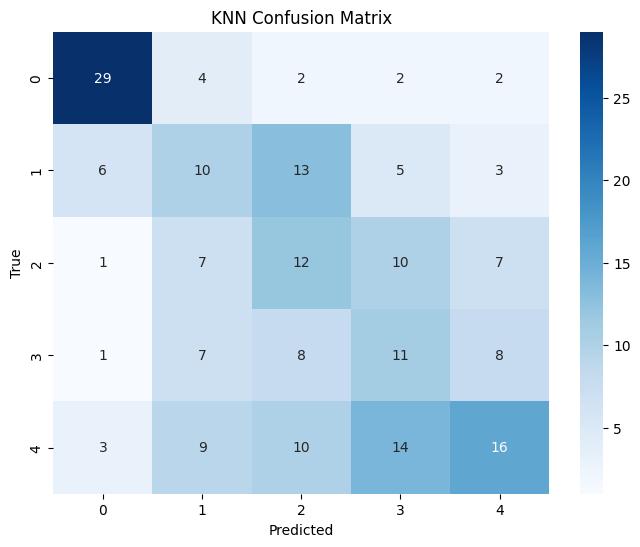


Training CNN Model

Starting CNN training for 20 epochs...
Epoch 1/20: Train Loss: 1.4762, Val Acc: 0.3788
Epoch 2/20: Train Loss: 1.1995, Val Acc: 0.4343
Epoch 3/20: Train Loss: 0.9806, Val Acc: 0.5101
Epoch 4/20: Train Loss: 0.7822, Val Acc: 0.4848
Epoch 5/20: Train Loss: 0.6467, Val Acc: 0.4545
Epoch 6/20: Train Loss: 0.5865, Val Acc: 0.5000
Epoch 7/20: Train Loss: 0.4625, Val Acc: 0.5253
Epoch 8/20: Train Loss: 0.3596, Val Acc: 0.4949
Epoch 9/20: Train Loss: 0.2417, Val Acc: 0.4747
Epoch 10/20: Train Loss: 0.3401, Val Acc: 0.5000
Epoch 11/20: Train Loss: 0.3177, Val Acc: 0.5455
Epoch 12/20: Train Loss: 0.2532, Val Acc: 0.5303
Epoch 13/20: Train Loss: 0.1784, Val Acc: 0.5404
Epoch 14/20: Train Loss: 0.2068, Val Acc: 0.5455
Epoch 15/20: Train Loss: 0.1374, Val Acc: 0.5455
Epoch 16/20: Train Loss: 0.1177, Val Acc: 0.5455
Epoch 17/20: Train Loss: 0.0796, Val Acc: 0.5606
Epoch 18/20: Train Loss: 0.0472, Val Acc: 0.5606
Epoch 19/20: Train Loss: 0.0201, Val Acc: 0.5606
Epoch 20/20: Train

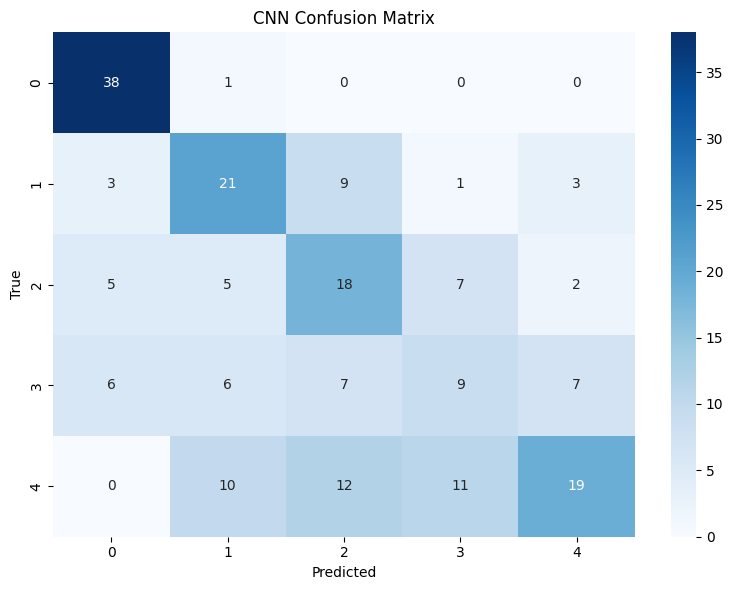


Model Comparison
KNN - Test Accuracy: 0.3900, MAE: 0.99
CNN - Test Accuracy: 0.5250, MAE: 0.80

Target accuracy not reached.


In [23]:
# Run
if __name__ == '__main__':
    main()